In [1]:
import numpy as np
import pandas as pd

# Load data
data = pd.read_csv('test_model.csv')

# Explore data
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Engine rpm        399 non-null    int64  
 1   Lub oil pressure  399 non-null    float64
 2   Fuel pressure     399 non-null    float64
 3   Coolant pressure  399 non-null    float64
 4   lub oil temp      399 non-null    float64
 5   Coolant temp      399 non-null    float64
 6   Engine Condition  399 non-null    int64  
dtypes: float64(5), int64(2)
memory usage: 21.9 KB


,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine Condition
0,700,2.493592,11.790927,3.178981,84.144163,81.632187,1
1,876,2.941606,16.193866,2.464504,77.640934,82.445724,0
2,520,2.961746,6.553147,1.064347,77.752266,79.645777,1
3,473,3.707835,19.510172,3.727455,74.129907,71.774629,1
4,619,5.672919,15.738871,2.052251,78.396989,87.000225,0


In [44]:
# Derive new features
data['Engine_power'] = data['Engine rpm'] * data['Lub oil pressure']
data['Temperature_difference'] = data['Coolant temp'] - data['lub oil temp']

# Drop unnecessary features
data.drop(['Engine_power'], axis=1, inplace=True)
data.describe().T


,count,mean,std,min,25%,50%,75%,max
Engine rpm,399.0,795.385965,273.187644,367.000000,597.000000,740.000000,931.500000,2143.000000
Lub oil pressure,399.0,3.281275,0.968793,0.143225,2.578068,3.214466,3.958395,5.672919
Fuel pressure,399.0,6.559783,2.827710,0.314028,4.781132,6.150238,7.544531,19.510172
Coolant pressure,399.0,2.273016,0.972640,0.155650,1.566810,2.174930,2.776851,7.478505
lub oil temp,399.0,77.992217,3.083587,72.986079,75.996214,77.118555,78.451762,88.602734
Coolant temp,399.0,78.513457,6.548229,63.970676,73.305891,78.231790,83.404731,95.234554
Engine Condition,399.0,0.593985,0.491704,0.000000,0.000000,1.000000,1.000000,1.000000
Temperature_difference,399.0,0.521240,7.199974,-19.322513,-4.391531,0.411465,5.603265,18.362550


In [45]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Define features and target
X = data.drop(['Engine Condition'], axis=1)
y = data['Engine Condition']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Train model
model = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42,
    max_features='sqrt', min_samples_leaf=5, min_samples_split=2, subsample=0.8
)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy Score: 0.60625
              precision    recall  f1-score   support

           0       0.49      0.44      0.46        62
           1       0.67      0.71      0.69        98

    accuracy                           0.61       160
   macro avg       0.58      0.57      0.58       160
weighted avg       0.60      0.61      0.60       160



In [46]:
import pickle

# Save model
with open('hhmodel.pkl', 'wb') as f:
    pickle.dump(model, f)


In [47]:
# Predict probabilities
probabilities = model.predict_proba(X_test)[:, 1]

# Define threshold
threshold = 0.6

# Identify maintenance indices
maintenance_indices = [i for i in range(len(probabilities)) if probabilities[i] > threshold]

# Convert indices to ranges
maintenance_ranges = []
if maintenance_indices:
    start_index = maintenance_indices[0]
    for i in range(1, len(maintenance_indices)):
        if maintenance_indices[i] != maintenance_indices[i-1] + 1:
            end_index = maintenance_indices[i-1]
            maintenance_ranges.append((start_index, end_index))
            start_index = maintenance_indices[i]
    end_index = maintenance_indices[-1]
    maintenance_ranges.append((start_index, end_index))
    print("Maintenance ranges:", maintenance_ranges)
else:
    print("No maintenance needed.")


Maintenance ranges: [(1, 6), (9, 14), (17, 21), (23, 26), (30, 31), (33, 35), (38, 38), (40, 40), (42, 43), (45, 45), (49, 49), (51, 52), (56, 56), (61, 62), (66, 66), (70, 70), (72, 72), (74, 75), (77, 80), (82, 82), (84, 86), (89, 93), (97, 98), (100, 100), (102, 102), (105, 106), (109, 111), (120, 123), (125, 125), (127, 127), (129, 129), (132, 133), (136, 137), (142, 143), (146, 149), (151, 151), (153, 154), (157, 158)]


In [38]:
# Define thresholds for parameters
thresholds = {
    'Engine rpm': 0.4, 'Lub oil pressure': 0.7, 'Fuel pressure': 0.6,
    'Coolant pressure': 0.7, 'lub oil temp': 0.65,
    'Coolant temp': 0.6, 'Temperature_difference': 0.65
}

# Identify and summarize maintenance days
maintenance_days = {}
for param, threshold in thresholds.items():
    param_probabilities = probabilities
    indices = [i for i in range(len(param_probabilities)) if param_probabilities[i] > threshold]
    maintenance_days[param] = [end - start + 1 for start, end in maintenance_ranges if start in indices]

print("Maintenance days:", maintenance_days)


Maintenance days: {'Engine rpm': [1, 3, 3, 2, 1, 1, 2, 1, 1, 1, 3, 1, 2, 2, 1, 4, 3, 5, 2, 2, 2, 4, 1, 3, 2, 1, 2, 3, 2, 2, 5, 2, 2, 4, 4, 2, 1, 1, 2, 6, 3, 1, 3, 7, 1, 4, 3, 7, 3, 2, 1, 3, 2, 3, 1, 3, 1, 1, 1, 1, 2, 1, 1, 7, 1, 1, 1, 8, 1, 3, 1, 4, 1, 1, 3, 2, 7, 1, 2, 1, 1, 1, 2, 2, 1, 3, 5, 4, 5, 1, 1, 1, 6, 1, 1, 2, 7, 1, 3, 5, 1, 2, 1, 1, 2, 6, 3, 1, 3, 1, 1, 1, 2, 3, 2, 1, 3, 1, 1, 4, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 9, 2, 1, 1, 4, 7, 1, 5, 2, 2, 1, 5, 5, 1, 8, 1, 4, 1, 3, 6, 1, 2, 1, 1, 1, 2, 2, 1, 3, 1, 2, 1, 2, 1, 1, 7, 2, 3, 1, 3, 7, 2, 3, 2, 5, 5, 1, 3, 2, 1, 6, 1, 1, 3, 2, 1, 2, 3, 2, 3, 2, 1, 1, 1, 7, 2, 1, 1, 1, 1, 2, 2, 2, 4, 4, 1, 1, 2, 1, 1, 2, 1, 3, 1, 1, 2, 1, 1, 2, 1, 3, 1, 1, 1, 1, 2, 3, 3, 2, 2, 1, 1, 3, 1, 1, 2, 1, 1, 10, 4, 2, 3, 1, 1, 2, 3, 1, 3, 1, 1, 6, 2, 4, 3, 1, 1, 1, 6, 1, 1, 3, 2, 2, 6, 1, 2, 1, 1, 2, 1, 3, 1, 1, 2, 3, 1, 1, 2, 6, 1, 1, 1, 1, 2, 2, 4, 1, 1, 2, 2, 6, 1, 1, 5, 1, 1, 2, 9, 1, 1, 1, 7, 5, 1, 1, 1, 2, 1, 3, 1, 1, 1, 4, 2, 1, 1, 1, 3, 3, 4, 6,

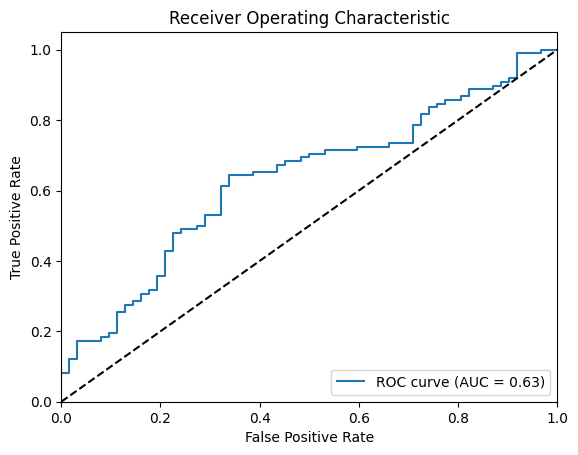

In [48]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute and plot ROC curve
fpr, tpr, _ = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [49]:
# Define binary values and weights
binary_values = {'Engine rpm': 1, 'Lub oil pressure': 0, 'Fuel pressure': 1,
                 'Coolant pressure': 0, 'lub oil temp': 0, 'Coolant temp': 1,
                 'Temperature_difference': 0}
weights = {'Engine rpm': 0.07, 'Lub oil pressure': 0.21, 'Fuel pressure': 0.14,
           'Coolant pressure': 0.7, 'lub oil temp': 0.14, 'Coolant temp': 0.21,
           'Temperature_difference': 0.7}

# Calculate weighted sum
weighted_sum = sum(binary_values[param] * weights[param] for param in binary_values)
print("Weighted sum:", weighted_sum)


Weighted sum: 0.42000000000000004
